In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 13.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
from sklearn import preprocessing
from datasets import Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score
)
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from transformers import TextClassificationPipeline
import torch
import os
import joblib
import json
import warnings
warnings.filterwarnings('ignore')


In [ ]:
#Loading File
df1 = pd.read_csv("/content/drive/MyDrive/SNLP_Project/sample_benchmarks/VagueQueries_Llama3.csv")
df2 = pd.read_csv("/content/drive/MyDrive/SNLP_Project/sample_benchmarks/VerboseQueries_Llama3.csv")

In [ ]:
df1 = df1[df1['Type'] != 'Verbose']

In [ ]:
df1['Type'].value_counts()

,count
Type,
vague,774


In [ ]:
df1.isna().sum()

,0
OriginalQuery,0
RewrittenQuery,12
Type,0


In [ ]:
df1['RewrittenQuery'] = df1['RewrittenQuery'].replace(["", " ", "NaN", np.nan], np.nan)
df1 = df1.dropna(subset=["RewrittenQuery"]).reset_index(drop=True)


In [ ]:
df1['Type'].value_counts()

,count
Type,
vague,762


In [ ]:
df2['Type'].value_counts()

,count
Type,
Verbose,774


In [ ]:
df2.isna().sum()

,0
OriginalQuery,0
RewrittenQuery,0
Type,0


In [ ]:
df = pd.concat([
    df1.drop('OriginalQuery', axis=1),
    df2.drop('OriginalQuery', axis=1)
], ignore_index=True)


In [ ]:
df.shape

(1536, 2)

In [ ]:
df['Type'].value_counts()

,count
Type,
Verbose,774
vague,762


In [ ]:
class TextCleaner():
    def __init__(self):
        pass

    def clean_text(self, text):
        if not isinstance(text, str):
            return text  # Return unchanged if not a string

        # Strip leading/trailing quotes, spaces, tabs, newlines
        text = text.strip(' "\'\n\t')

        # Remove long sequences of dashes, even with spaces between
        text = re.sub(r"(-\s*){3,}", "", text)

        # Optionally strip again after dash removal
        text = text.strip()

        return text

# Apply to your DataFrame
cleaner = TextCleaner()
df['RewrittenQuery'] = df['RewrittenQuery'].apply(cleaner.clean_text)


In [ ]:
df.head()

,RewrittenQuery,Type
0,What is the typical duration of Marketing Affi...,vague
1,In what timeframe do Marketing Affiliate Agree...,vague
2,Are there any specified consequences for non-c...,vague
3,"In contracts between companies, what types of ...",vague
4,Are there common restrictions on the transfer ...,vague


In [ ]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)


In [ ]:
df.head(10)

,RewrittenQuery,Type
0,In what specific manner do the Closing Conditi...,Verbose
1,"In agreements for co-branded products, what is...",vague
2,What conditions might lead to the termination ...,vague
3,Does the Co-Branding and Endorsement Licensing...,Verbose
4,"Under what circumstances, if any, must the Rec...",Verbose
5,Does Viber Messenger's privacy policy adequate...,Verbose
6,What are the conditions under which Confidenti...,vague
7,Does the Non-Disclosure Agreement between IGC ...,Verbose
8,What is the specific date of contract expirati...,Verbose
9,What specific provisions within the Acquisitio...,Verbose


In [ ]:
# Split first
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["Type"])

# Fit encoder only on training data
label_encoder = preprocessing.LabelEncoder()
train_df['Type'] = label_encoder.fit_transform(train_df['Type'])

# Use same encoder on test set
test_df['Type'] = label_encoder.transform(test_df['Type'])


In [ ]:
print(label_encoder.classes_)


['Verbose' 'vague']


#Training Distillbert

In [ ]:
# Rename 'Type' column to 'labels' before tokenizing
train_df = train_df.rename(columns={"Type": "labels"})
test_df = test_df.rename(columns={"Type": "labels"})

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# Converting datasets to tokenized format
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

def tokenize_data(examples):
    return tokenizer(examples["RewrittenQuery"], truncation=True)

tokenized_train = train_dataset.map(tokenize_data, batched=True)
tokenized_test = test_dataset.map(tokenize_data, batched=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/1228 [00:00<?, ? examples/s]

Map:   0%|          | 0/308 [00:00<?, ? examples/s]

In [ ]:
# Loading pre-trained DistilBERT model for sequence classification
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

# Preparing data collator for padding sequences
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)

    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    acc = accuracy_score(labels, predictions)

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
}


training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)



Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Train the model
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ucabpxx (ucabpxx-university-college-london) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.105100,0.002919,1.000000,1.000000,1.000000,1.000000
2,0.001300,0.000585,1.000000,1.000000,1.000000,1.000000
3,0.000600,0.000365,1.000000,1.000000,1.000000,1.000000
4,0.000400,0.000244,1.000000,1.000000,1.000000,1.000000
5,0.000300,0.000217,1.000000,1.000000,1.000000,1.000000


TrainOutput(global_step=770, training_loss=0.021544416534242692, metrics={'train_runtime': 93.9354, 'train_samples_per_second': 65.364, 'train_steps_per_second': 8.197, 'total_flos': 119526989649792.0, 'train_loss': 0.021544416534242692, 'epoch': 5.0})

In [ ]:
# Evaluate after training
metrics = trainer.evaluate()
print(metrics)

{'eval_loss': 0.0002174394321627915, 'eval_accuracy': 1.0, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_runtime': 0.742, 'eval_samples_per_second': 415.067, 'eval_steps_per_second': 52.557, 'epoch': 5.0}


In [ ]:
# 1. Save fine-tuned DistilBERT model and tokenizer ===
drive_model_path = "/content/drive/MyDrive/bert_query_classifier"

# Create directory if not exists
os.makedirs(drive_model_path, exist_ok=True)

# Save model
trainer.save_model(drive_model_path)

# Save tokenizer
tokenizer.save_pretrained(drive_model_path)

# 2. Save LabelEncoder separately
label_encoder_path = os.path.join(drive_model_path, "label_encoder.joblib")
joblib.dump(label_encoder, label_encoder_path)

print("Model, tokenizer, and LabelEncoder saved successfully!")


Model, tokenizer, and LabelEncoder saved successfully!


# Loading

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from google.colab import drive
drive.mount('/content/drive')

# Path to saved model
model_path = "/content/drive/MyDrive/bert_query_classifier"

# Load the model and tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
trainer.save_model(drive_model_path)  # Same path, will overwrite
tokenizer.save_pretrained(drive_model_path)


('/content/drive/MyDrive/bert_query_classifier/tokenizer_config.json',
 '/content/drive/MyDrive/bert_query_classifier/special_tokens_map.json',
 '/content/drive/MyDrive/bert_query_classifier/vocab.txt',
 '/content/drive/MyDrive/bert_query_classifier/added_tokens.json',
 '/content/drive/MyDrive/bert_query_classifier/tokenizer.json')

# Random Forest Classifier - TF-IDF

In [ ]:
# Split first
train_df_random, test_df_random = train_test_split(df, test_size=0.2, stratify=df["Type"])

# Fit encoder only on training data
label_encoder = preprocessing.LabelEncoder()
train_df_random['Type'] = label_encoder.fit_transform(train_df_random['Type'])

# Use same encoder on test set
test_df_random['Type'] = label_encoder.transform(test_df_random['Type'])




In [ ]:
# 3. TF-IDF Vectorization
tfidf = TfidfVectorizer(
    lowercase=True,
    stop_words='english',
    ngram_range=(1, 2),
    max_df=0.85,
    min_df=2,
    max_features=5000
)

X_train_tfidf = tfidf.fit_transform(train_df_random['RewrittenQuery'])
X_test_tfidf = tfidf.transform(test_df_random['RewrittenQuery'])
y_train = train_df_random['Type']
y_test = test_df_random['Type']

# 4. Hyperparameter tuning with GridSearchCV
params = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid=params,
    cv=3,
    scoring='f1_weighted',
    n_jobs=-1
)
grid.fit(X_train_tfidf, y_train)
best_rf = grid.best_estimator_

# ✅ Print best hyperparameters and score
print("\nBest Hyperparameters from GridSearchCV:")
print(grid.best_params_)

print("\nBest Weighted F1 Score on Validation Set:")
print(round(grid.best_score_, 4))

# 5. Predict on test data
y_pred = best_rf.predict(X_test_tfidf)

# 6. Evaluation
def evaluate_model(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    precision_macro = precision_score(y_true, y_pred, average='macro')
    recall_macro = recall_score(y_true, y_pred, average='macro')
    f1_macro = f1_score(y_true, y_pred, average='macro')

    precision_weighted = precision_score(y_true, y_pred, average='weighted')
    recall_weighted = recall_score(y_true, y_pred, average='weighted')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')

    print("\nTest Set Evaluation:")
    print("Accuracy:", round(acc, 4))
    print("\nPrecision (Macro):", round(precision_macro, 4))
    print("Recall    (Macro):", round(recall_macro, 4))
    print("F1 Score  (Macro):", round(f1_macro, 4))

    print("\nPrecision (Weighted):", round(precision_weighted, 4))
    print("Recall    (Weighted):", round(recall_weighted, 4))
    print("F1 Score  (Weighted):", round(f1_weighted, 4))

    print("\nClassification Report:\n", classification_report(y_true, y_pred))

evaluate_model(y_test, y_pred)



Best Hyperparameters from GridSearchCV:
{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

Best Weighted F1 Score on Validation Set:
0.9976

Test Set Evaluation:
Accuracy: 0.9935

Precision (Macro): 0.9935
Recall    (Macro): 0.9935
F1 Score  (Macro): 0.9935

Precision (Weighted): 0.9936
Recall    (Weighted): 0.9935
F1 Score  (Weighted): 0.9935

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99       155
           1       0.99      1.00      0.99       153

    accuracy                           0.99       308
   macro avg       0.99      0.99      0.99       308
weighted avg       0.99      0.99      0.99       308



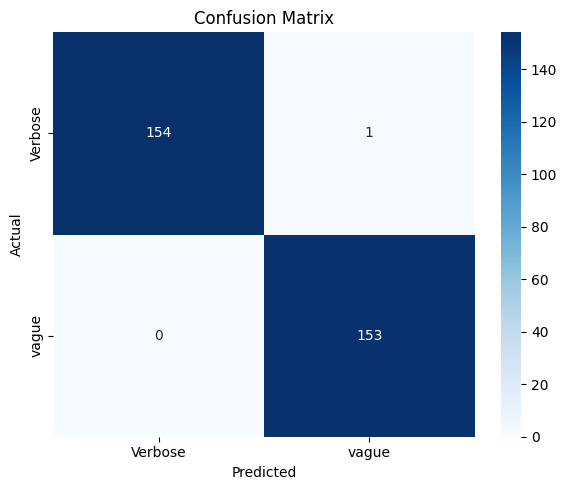

In [ ]:
# Generate confusion matrix
cm_random = confusion_matrix(y_test, y_pred)

# Optional: get class labels back if you used LabelEncoder
class_labels = label_encoder.classes_

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm_random, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


In [ ]:
# Ensure the directory exists
os.makedirs('/content/drive/MyDrive/Saved_Models', exist_ok=True)

# Define paths to your Google Drive folder
model_path = '/content/drive/MyDrive/Saved_Models/best_random_forest_model.joblib'
vectorizer_path = '/content/drive/MyDrive/Saved_Models/tfidf_vectorizer.joblib'
label_encoder_path = '/content/drive/MyDrive/Saved_Models/label_encoder.joblib'

# Save the best Random Forest model
joblib.dump(best_rf, model_path)

# Save the TF-IDF vectorizer
joblib.dump(tfidf, vectorizer_path)

# Save the Label Encoder
joblib.dump(label_encoder, label_encoder_path)  #

print(" Model, vectorizer, and label encoder saved to Google Drive!")


 Model, vectorizer, and label encoder saved to Google Drive!


# SVM

In [ ]:
params = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

grid = GridSearchCV(
    SVC(probability=True, random_state=42),
    param_grid=params,
    cv=3,
    scoring='f1_weighted',
    n_jobs=-1
)
grid.fit(X_train_tfidf, y_train)
best_svm = grid.best_estimator_

# rint best hyperparameters and score
print("\nBest Hyperparameters from GridSearchCV (SVM):")
print(grid.best_params_)

print("\nBest Weighted F1 Score on Validation Set:")
print(round(grid.best_score_, 4))

# 3. Predict on test data
y_pred = best_svm.predict(X_test_tfidf)

# 4. Evaluation
def evaluate_model(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    precision_macro = precision_score(y_true, y_pred, average='macro')
    recall_macro = recall_score(y_true, y_pred, average='macro')
    f1_macro = f1_score(y_true, y_pred, average='macro')

    precision_weighted = precision_score(y_true, y_pred, average='weighted')
    recall_weighted = recall_score(y_true, y_pred, average='weighted')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')

    print("\nTest Set Evaluation:")
    print("Accuracy:", round(acc, 4))
    print("\nPrecision (Macro):", round(precision_macro, 4))
    print("Recall    (Macro):", round(recall_macro, 4))
    print("F1 Score  (Macro):", round(f1_macro, 4))

    print("\nPrecision (Weighted):", round(precision_weighted, 4))
    print("Recall    (Weighted):", round(recall_weighted, 4))
    print("F1 Score  (Weighted):", round(f1_weighted, 4))

    print("\nClassification Report:\n", classification_report(y_true, y_pred))

evaluate_model(y_test, y_pred)



Best Hyperparameters from GridSearchCV (SVM):
{'C': 10, 'gamma': 'scale', 'kernel': 'linear'}

Best Weighted F1 Score on Validation Set:
0.9804

Test Set Evaluation:
Accuracy: 0.9805

Precision (Macro): 0.9806
Recall    (Macro): 0.9805
F1 Score  (Macro): 0.9805

Precision (Weighted): 0.9806
Recall    (Weighted): 0.9805
F1 Score  (Weighted): 0.9805

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       155
           1       0.99      0.97      0.98       153

    accuracy                           0.98       308
   macro avg       0.98      0.98      0.98       308
weighted avg       0.98      0.98      0.98       308



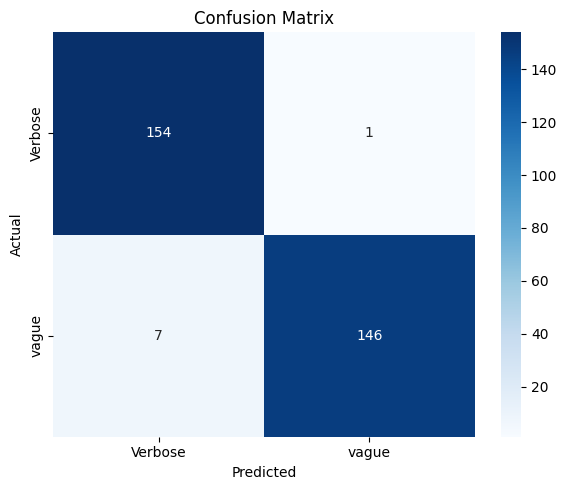

In [ ]:
#confusion matrix
cm_SVM = confusion_matrix(y_test, y_pred)

# Optional: get class labels back if you used LabelEncoder
class_labels = label_encoder.classes_

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm_SVM, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


In [ ]:


# Checking if directory exists
os.makedirs('/content/drive/MyDrive/Saved_Models', exist_ok=True)

svm_model_path = '/content/drive/MyDrive/Saved_Models/best_svm_model.joblib'
vectorizer_path = '/content/drive/MyDrive/Saved_Models/tfidf_vectorizer.joblib'
label_encoder_path = '/content/drive/MyDrive/Saved_Models/label_encoder.joblib'

# Saving the best SVM model
joblib.dump(best_svm, svm_model_path)

# Saving the TF-IDF vectorizer
joblib.dump(tfidf, vectorizer_path)

# Saving the Label Encoder
joblib.dump(label_encoder, label_encoder_path)

print("SVM model, vectorizer, and label encoder saved to Google Drive!")


SVM model, vectorizer, and label encoder saved to Google Drive!


# Testing Data

In [ ]:
# Define JSON file paths
base_path = "/content/drive/MyDrive/SNLP_Project"
file_names = ["contractnli.json", "cuad.json", "maud.json", "privacy_qa.json"]
file_paths = [f"{base_path}/{name}" for name in file_names]

# Initialize list to collect all 'only_question' entries
only_questions = []

# Function to safely extract 'only_question' from query_rewriter field
def extract_only_questions(df):
    return [
        item[0].get("only_question")
        for item in df.get("query_rewriter", [])
        if isinstance(item, list) and len(item) > 0 and "only_question" in item[0]
    ]

# Process each file
for path in file_paths:
    try:
        df = pd.read_json(path)
        only_questions.extend(extract_only_questions(df))
        print(f"Extracted from: {path}")
    except Exception as e:
        print(f"Error processing {path}: {e}")

# Previewing results
print(f"\nTotal questions extracted: {len(only_questions)}")
for query in only_questions[:5]:
    print(f"Query: {query}")

Extracted from: /content/drive/MyDrive/SNLP_Project/contractnli.json
Extracted from: /content/drive/MyDrive/SNLP_Project/cuad.json
Extracted from: /content/drive/MyDrive/SNLP_Project/maud.json
Extracted from: /content/drive/MyDrive/SNLP_Project/privacy_qa.json

Total questions extracted: 774
Query: Does the document indicate that the Agreement does not grant the Receiving Party any rights to the Confidential Information?
Query: Does the document state that Confidential Information shall only include technical information?
Query: Does the document mention that some obligations of the Agreement may survive the termination of the Agreement?
Query: Does the document permit the Receiving Party to retain some Confidential Information even after its return or destruction?
Query: Does the document allow the Receiving Party to share some Confidential Information with third parties, including consultants, agents, and professional advisors?


# Testing Model Distillbert

In [ ]:
# Load model and tokenizer
model_path = "/content/drive/MyDrive/bert_query_classifier"
model_distillbert = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

# Load label encoder
label_encoder = joblib.load(os.path.join(model_path, "label_encoder.joblib"))


In [ ]:
# Create the classification pipeline
pipe = TextClassificationPipeline(
    model=model_distillbert,
    tokenizer=tokenizer,
    return_all_scores=False,
    truncation=True,
    padding=True,
    device=0 if torch.cuda.is_available() else -1
)

# Run classification
predictions = pipe(only_questions)

# Prepare results for JSON
results = []
for query, pred in zip(only_questions, predictions):
    label_id = int(pred['label'].split('_')[-1])
    class_name = label_encoder.inverse_transform([label_id])[0]

    results.append({
        "query": query,
        "class": class_name,
        "label": pred['label'],
        "confidence": round(pred['score'], 4)
    })

# Save results to JSON
output_path = "/content/drive/MyDrive/SNLP_Project/query_predictions.json"
with open(output_path, "w") as f:
    json.dump(results, f, indent=2)

print(f"Results saved to {output_path}")


Device set to use cuda:0


Results saved to /content/drive/MyDrive/SNLP_Project/query_predictions.json


# Testing using Random Forest

In [ ]:
# 1. Load saved model and vectorizer
loaded_model_rf = joblib.load('/content/drive/MyDrive/Saved_Models/best_random_forest_model.joblib')
loaded_vectorizer_rf = joblib.load('/content/drive/MyDrive/Saved_Models/tfidf_vectorizer.joblib')
loaded_label_encoder = joblib.load('/content/drive/MyDrive/Saved_Models/label_encoder.joblib')

# 2. Transform new queries using the loaded TF-IDF vectorizer
X_new = loaded_vectorizer_rf.transform(only_questions)

# 3. Predict using the loaded model
pred_labels = loaded_model_rf.predict(X_new)

# 4. Decode labels to class names using saved LabelEncoder
pred_classes = loaded_label_encoder.inverse_transform(pred_labels)

# 5. Prepare and print results
results = []
print("Random Forest Predictions:")
for query, label_num, label_name in zip(only_questions, pred_labels, pred_classes):
    result = {
        "query": query,
        "label": int(label_num),
        "class": label_name
    }
    results.append(result)
    print(json.dumps(result, indent=2))  # Pretty-print each result

# 6. Save to JSON file
output_path = "/content/drive/MyDrive/SNLP_Project/rf_query_predictions.json"
with open(output_path, "w") as f:
    json.dump(results, f, indent=2)

print(f"\n Random Forest classification results saved to: {output_path}")


Random Forest Predictions:
{
  "query": "Does the document indicate that the Agreement does not grant the Receiving Party any rights to the Confidential Information?",
  "label": 1,
  "class": "vague"
}
{
  "query": "Does the document state that Confidential Information shall only include technical information?",
  "label": 1,
  "class": "vague"
}
{
  "query": "Does the document mention that some obligations of the Agreement may survive the termination of the Agreement?",
  "label": 0,
  "class": "Verbose"
}
{
  "query": "Does the document permit the Receiving Party to retain some Confidential Information even after its return or destruction?",
  "label": 1,
  "class": "vague"
}
{
  "query": "Does the document allow the Receiving Party to share some Confidential Information with third parties, including consultants, agents, and professional advisors?",
  "label": 0,
  "class": "Verbose"
}
{
  "query": "Does the document require the Receiving Party to notify the Disclosing Party if they

# Testing using svm

In [ ]:
# 1. Load saved model and vectorizer
loaded_model_svm = joblib.load('/content/drive/MyDrive/Saved_Models/best_svm_model.joblib')
loaded_vectorizer_svm = joblib.load('/content/drive/MyDrive/Saved_Models/tfidf_vectorizer.joblib')
loaded_label_encoder = joblib.load('/content/drive/MyDrive/Saved_Models/label_encoder.joblib')

# 2. Transform new queries using the loaded TF-IDF vectorizer
X_new = loaded_vectorizer_svm.transform(only_questions)

# 3. Predict using the loaded model
pred_labels = loaded_model_svm.predict(X_new)

# 4. Decode labels to class names using saved LabelEncoder
pred_classes = loaded_label_encoder.inverse_transform(pred_labels)


# 5. Prepare and print results
results = []
print("SVM Predictions:")
for query, label_num, label_name in zip(only_questions, pred_labels, pred_classes):
    result = {
        "query": query,
        "label": int(label_num),
        "class": label_name
    }
    results.append(result)
    print(json.dumps(result, indent=2))  # Pretty-print each result

# 6. Save to JSON file
output_path = "/content/drive/MyDrive/SNLP_Project/svm_query_predictions.json"
with open(output_path, "w") as f:
    json.dump(results, f, indent=2)

print(f"\nSVM classification results saved to: {output_path}")


SVM Predictions:
{
  "query": "Does the document indicate that the Agreement does not grant the Receiving Party any rights to the Confidential Information?",
  "label": 1,
  "class": "vague"
}
{
  "query": "Does the document state that Confidential Information shall only include technical information?",
  "label": 1,
  "class": "vague"
}
{
  "query": "Does the document mention that some obligations of the Agreement may survive the termination of the Agreement?",
  "label": 1,
  "class": "vague"
}
{
  "query": "Does the document permit the Receiving Party to retain some Confidential Information even after its return or destruction?",
  "label": 0,
  "class": "Verbose"
}
{
  "query": "Does the document allow the Receiving Party to share some Confidential Information with third parties, including consultants, agents, and professional advisors?",
  "label": 1,
  "class": "vague"
}
{
  "query": "Does the document require the Receiving Party to notify the Disclosing Party if they are require